In [1]:
!git clone https://github.com/joel1895/track
#!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 25471, done.
remote: Total 25471 (delta 0), reused 0 (delta 0), pack-reused 25471
Receiving objects: 100% (25471/25471), 327.29 MiB | 36.20 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (15275/15275), done.


In [2]:
!ls track

driving_log.csv  IMG


In [0]:
#!pip3 install imgaug

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import keras
from sklearn.utils import shuffle
from keras.layers import Convolution2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import random
import ntpath
import os
import tensorflow as tf


Using TensorFlow backend.


In [5]:
datadir = 'track'
columns = ['centre','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

,centre,left,right,steering,throttle,reverse,speed
0,/Users/joel/Desktop/Data/IMG/center_2019_11_17_16_57_21_049.jpg,/Users/joel/Desktop/Data/IMG/left_2019_11_17_16_57_21_049.jpg,/Users/joel/Desktop/Data/IMG/right_2019_11_17_16_57_21_049.jpg,0.0,0.0,0.0,0.000082
1,/Users/joel/Desktop/Data/IMG/center_2019_11_17_16_57_21_154.jpg,/Users/joel/Desktop/Data/IMG/left_2019_11_17_16_57_21_154.jpg,/Users/joel/Desktop/Data/IMG/right_2019_11_17_16_57_21_154.jpg,0.0,0.0,0.0,0.000078
2,/Users/joel/Desktop/Data/IMG/center_2019_11_17_16_57_21_257.jpg,/Users/joel/Desktop/Data/IMG/left_2019_11_17_16_57_21_257.jpg,/Users/joel/Desktop/Data/IMG/right_2019_11_17_16_57_21_257.jpg,0.0,0.0,0.0,0.000082
3,/Users/joel/Desktop/Data/IMG/center_2019_11_17_16_57_21_357.jpg,/Users/joel/Desktop/Data/IMG/left_2019_11_17_16_57_21_357.jpg,/Users/joel/Desktop/Data/IMG/right_2019_11_17_16_57_21_357.jpg,0.0,0.0,0.0,0.000079
4,/Users/joel/Desktop/Data/IMG/center_2019_11_17_16_57_21_460.jpg,/Users/joel/Desktop/Data/IMG/left_2019_11_17_16_57_21_460.jpg,/Users/joel/Desktop/Data/IMG/right_2019_11_17_16_57_21_460.jpg,0.0,0.0,0.0,0.000079


In [0]:
def path_leaf(path):
  head,tail = ntpath.split(path)
  return tail

data['centre'] = data['centre'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,centre,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [0]:
num_bins = 25
samples_per_bin = 400
hist,bins = np.histogram(data['steering'],num_bins) # hist gives the height,bins gives x-axis
center = (bins[:-1]+bins[1:])*0.5
print(center)

[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


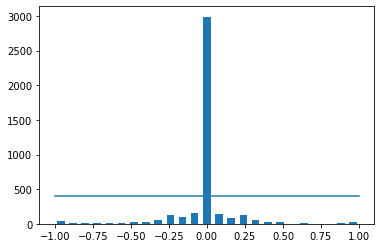

In [0]:
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

total data:  4053
removed:  2590
remaining:  1463


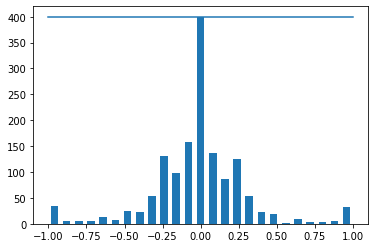

In [0]:
print('total data: ',len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i]<=bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
 
  list_ = list_[samples_per_bin:]
 
  remove_list.extend(list_)
print('removed: ',len(remove_list))
data.drop(data.index[remove_list],inplace=True)
print('remaining: ',len(data))

hist,_  = np.histogram(data['steering'],num_bins)
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [0]:
data.iloc[0]
def load_img_steering(datadir,data):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center,left,right = indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steering = np.asarray(steering)
  return image_paths,steering

image_paths,steerings = load_img_steering(datadir+'/IMG',data)



In [0]:
image_paths[0]

'track/IMG/center_2018_07_16_17_11_43_724.jpg'

In [0]:
X_train,X_valid,y_train,y_valid = train_test_split(image_paths,steerings,test_size=0.2,random_state=6)
print('Training samples: {}\nValidation samples: {}'.format(len(X_train),len(X_valid)))

Training samples: 1170
Validation samples: 293


Text(0.5, 1.0, 'Validation set')

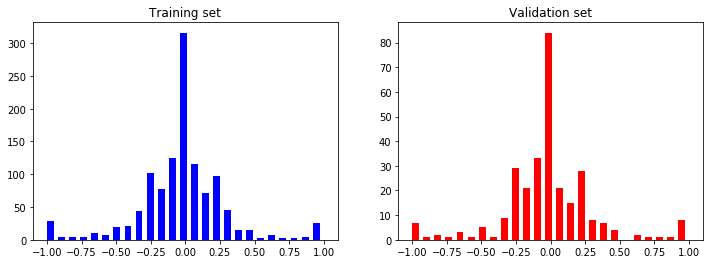

In [0]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
axes[0].hist(y_train,bins=num_bins,width=0.05,color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid,bins=num_bins,width=0.05,color='red')
axes[1].set_title('Validation set')

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image


Text(0.5, 1, 'Zommed Image')

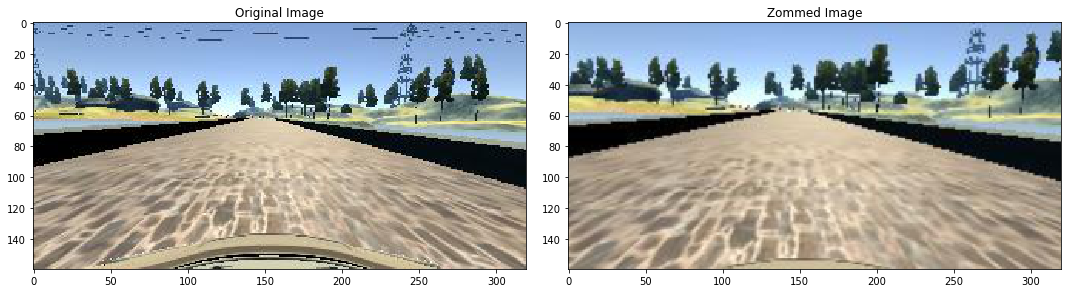

In [0]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig,ax = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

ax[0].imshow(original_image)
ax[0].set_title('Original Image')

ax[1].imshow(zoomed_image)
ax[1].set_title('Zommed Image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent=({'x':(-0.1,0.1),'y':(-0.1,0.1)}))
  image = pan.augment_image(image)
  return image


Text(0.5, 1, 'Panned Image')

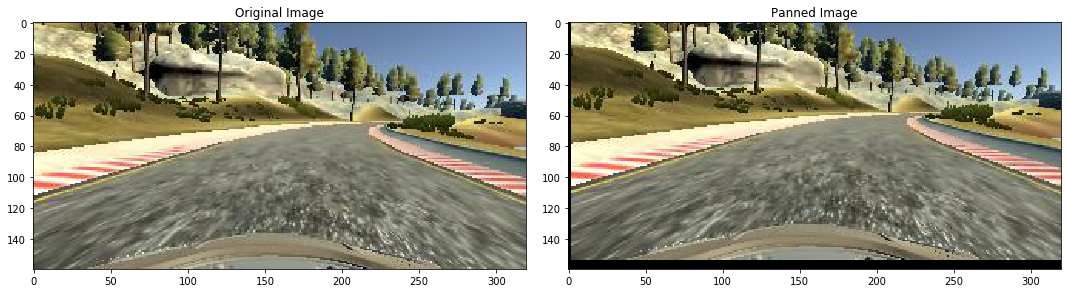

In [0]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig,ax = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

ax[0].imshow(original_image)
ax[0].set_title('Original Image')

ax[1].imshow(panned_image)
ax[1].set_title('Panned Image')

In [0]:
def image_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brighteness altered image')

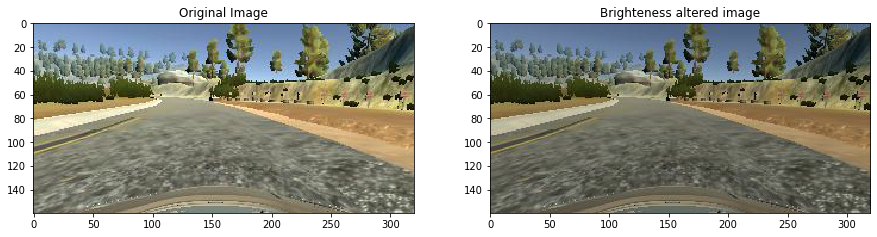

In [0]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
bright_image = image_random_brightness(original_image)

fig,ax = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout

ax[0].imshow(original_image)
ax[0].set_title('Original Image')

ax[1].imshow(bright_image)
ax[1].set_title('Brighteness altered image')

In [0]:
def img_random_flip(image,steering_angle):
  image = cv2.flip(image,1)
  steering_angle = -steering_angle
  
  return image,steering_angle
  

Text(0.5, 1, 'Flipped image with steering angle: 0.3')

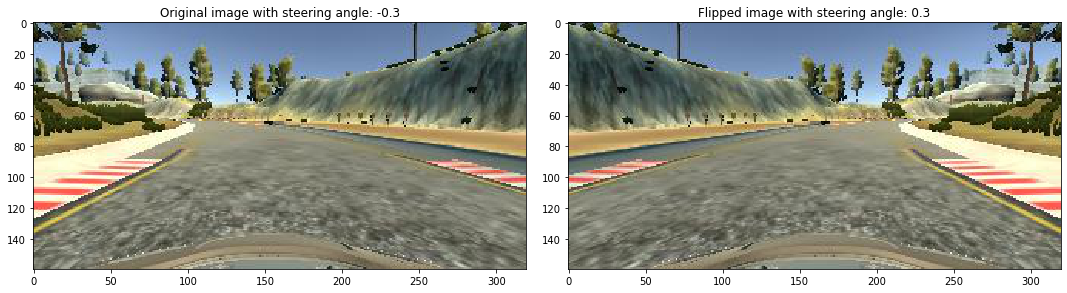

In [0]:
random_index = random.randint(0,100)
image = image_paths[random_index]
original_image = mpimg.imread(image)
steering_angle = steerings[random_index]

flipped_image,flipped_steering_angle = img_random_flip(original_image,steering_angle)

fig,ax = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

ax[0].imshow(original_image)
ax[0].set_title('Original image with steering angle: '+str(steering_angle))

ax[1].imshow(flipped_image)
ax[1].set_title('Flipped image with steering angle: '+str(flipped_steering_angle))

In [0]:
def random_augment(image,steering_angle):
  image = mpimg.imread(image)

  if np.random.rand()<0.5:
    image = zoom(image)
  
  if np.random.rand()<0.5:
    image = image_random_brightness(image)
  
  if np.random.rand()<0.5:
    image = pan(image)

  if np.random.rand()<0.5:
    image,steering_angle = img_random_flip(image,steering_angle)

  return image,steering_angle

In [0]:
nrows = 10
ncols = 2

fig,ax = plt.subplots(nrows,ncols,figsize=(15,50))

for i in range(10):
  randnum = random.randint(0,10)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image,steering = random_augment(random_image,random_steering)

  ax[i][0].imshow(original_image)
  ax[i][0].set_title('Original Image')

  ax[i][1].imshow(augmented_image)
  ax[i][1].set_title('Augmented Image')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
def img_preprocess(img):
  #img = mpimg.imread(img)
  img = img[60:135,:,:]
  img = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
  img = cv2.GaussianBlur(img,(3,3),0)
  img = cv2.resize(img,(200,66))
  img = img/255
  return img

Text(0.5, 1, 'Preprocessed image')

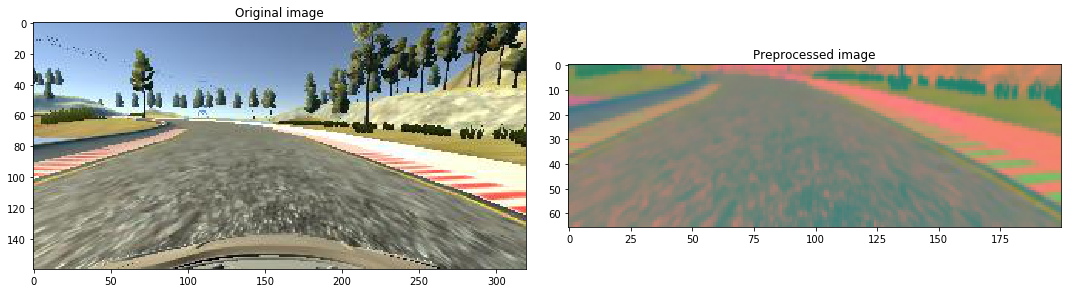

In [0]:
image = image_paths[200]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed image')

In [0]:
def batch_generator(image_path,steering_angle,batch_size,istraining):
  while True:
    batch_image =[]
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0,len(image_path)-1)
      if istraining:
        im,steering = random_augment(image_path[random_index],steering_angle[random_index])
      else:
        im = mpimg.imread(image_path[random_index])
        steering = steering_angle[random_index]
      im = img_preprocess(im)
      batch_image.append(im)
      batch_steering.append(steering)
    
    yield(np.asarray(batch_image),np.asarray(batch_steering))



Text(0.5, 1, 'Validation Image')

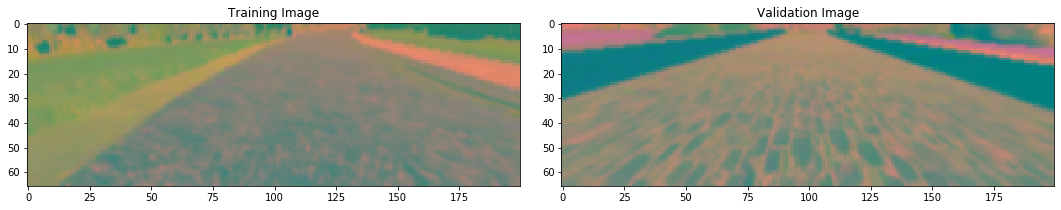

In [0]:
X_train_gen,y_train_gen = next(batch_generator(X_train,y_train,1,1))
X_valid_gen,y_train_gen = next(batch_generator(X_valid,y_valid,1,0))

fig,ax = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

ax[0].imshow(X_train_gen[0])
ax[0].set_title("Training Image")

ax[1].imshow(X_valid_gen[0])
ax[1].set_title("Validation Image")

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24,5,5,subsample=(2,2),input_shape=(66,200,3),activation='elu'))
  model.add(Convolution2D(36,5,5,subsample=(2,2),activation='elu'))
  model.add(Convolution2D(48,5,5,subsample=(2,2),activation='elu'))
  model.add(Convolution2D(64,3,3,activation='elu'))
  model.add(Convolution2D(64,3,3,activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100,activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(50,activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(10,activation='elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(1))

  model.compile(loss='mse',optimizer=Adam(lr=1e-4),)
  return model

In [0]:
model = nvidia_model()
print(model.summary())





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

In [0]:
history = model.fit_generator(batch_generator(X_train,y_train,100,1),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data=batch_generator(X_valid,y_valid,100,0),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1)




Epoch 1/10





300/300 [==============================] - 181s 603ms/step - loss: 0.0797 - val_loss: 0.0533
Epoch 2/10
300/300 [==============================] - 166s 555ms/step - loss: 0.0573 - val_loss: 0.0533
Epoch 3/10
300/300 [==============================] - 165s 550ms/step - loss: 0.0540 - val_loss: 0.0476
Epoch 4/10
300/300 [==============================] - 164s 545ms/step - loss: 0.0483 - val_loss: 0.0443
Epoch 5/10
300/300 [==============================] - 164s 547ms/step - loss: 0.0424 - val_loss: 0.0400
Epoch 6/10
300/300 [==============================] - 164s 546ms/step - loss: 0.0405 - val_loss: 0.0426
Epoch 7/10
300/300 [==============================] - 164s 546ms/step - loss: 0.0386 - val_loss: 0.0399
Epoch 8/10
300/300 [==============================] - 164s 548ms/step - loss: 0.0367 - val_loss: 0.0370
Epoch 9/10
300/300 [==============================] - 164s 546ms/step - loss: 0.0344 - val_loss: 0.0335
Epoch 10/10
300/300 [==============================] - 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("co...)`
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("co...)`
  


(1, 31, 98, 24)
(1, 5, 22, 48)


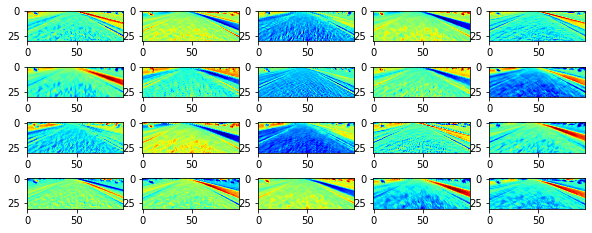

In [0]:
layer1 = Model(inputs=model.layers[0].input,output=model.layers[0].output)
layer2 = Model(inputs=model.layers[0].input,output=model.layers[2].output)
a = mpimg.imread(X_train[0])
a = img_preprocess(a)
a = a.reshape(1,66,200,3)
visual_layer1,visual_layer2 = layer1.predict(a),layer2.predict(a)
print(visual_layer1.shape)
print(visual_layer2.shape)
plt.figure(figsize=(10,6))
for i in range(20):
  plt.subplot(6,5,i+1)
  plt.imshow(visual_layer1[0,:,:,i],cmap=plt.get_cmap('jet')) 

Text(0, 0.5, 'loss')

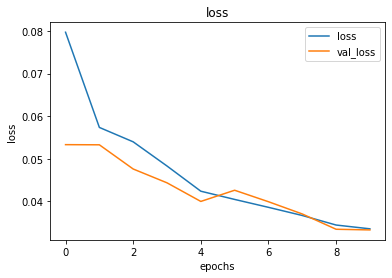

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend(['loss','val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [0]:
 model.save('model.h5')

In [0]:
 from google.colab import files
 files.download('model.h5')

MessageError: ignored

In [0]:
y = next(x)
print(y)